# BARLOW TWINS

## SETUP

In [1]:
%cd ~/Documents/TESI/TESI/notebooks
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/TESI/notebooks


/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import tifffile
import glob
import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
)

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False:


2.6.0+cu124
1.4.0


In [3]:
from utils.setup_functions import set_environment_flags
# Example usage:
environment_flags = set_environment_flags()
kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

Environment settings: {'gdrive': False, 'linux': True, 'kaggle': False, 'ssl': True}


In [4]:
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [5]:
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
from utils.directory_functions import get_data_and_base_directory
data_dir, base_dir = get_data_and_base_directory(environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"], num_input_channels=num_input_channels)

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new


# DATA EXTRACTION

In [6]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [7]:
## Paths of ALL images into a numpy array without labels used for SSL
def from_tif_folder_to_np_paths_array(folder_path: str) -> np.ndarray:
    """
    Load all .tif images from a folder into a numpy array.
    """
    image_paths = glob.glob(os.path.join(folder_path, "*.tif"))
    image_paths_np = np.array(image_paths)
    print(f"Number of images in {folder_path}: {len(image_paths)}")
    return image_paths_np

all_images_folder_path = os.path.join(data_dir, "ALL")
all_images_paths = from_tif_folder_to_np_paths_array(all_images_folder_path)
print("Number of images in ALL folder:", len(all_images_paths))

Number of images in /home/zano/Documents/TESI/3c_MIP_new/ALL: 152
Number of images in ALL folder: 152


In [8]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    

ssl_images_paths_np = from_tif_folder_to_np_paths_array(ssl_images_folder_path)
print(f"Number of images in {ssl_images_folder_path} folder:", len(ssl_images_paths_np))

['MSA', 'PD']
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL: 18
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL folder: 18


{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA images (before filtering): 'gh' count: 83, 'vaso' count: 0
Number of glandular images before filtering: 83
Number of glandular images after filtering: 83
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
Number of glandular images before filtering: 57
Number of glandular images after filtering: 57


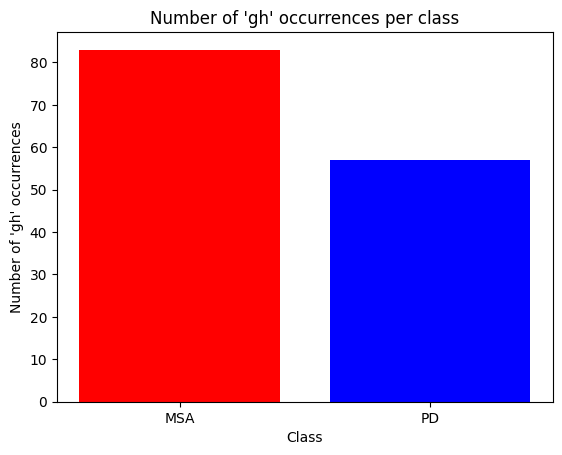


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif.tif  dt

In [9]:
# Create a dictionary mapping each class to its directory
class_dirs = {} # { "class_name": "path/to/class_dir", "class_name2": "path/to/class_dir2", ... }
is_three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if is_three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    from utils.data_extraction_functions import remove_non_gland_images
    image_paths = remove_non_gland_images(image_paths)
    # counts after filtering
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    # print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
# def plot_counts_bar_chart(counts_dict, class_names):
#     """
#     Plot a bar chart of counts for each class.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_names, [counts_dict[cn]["gh_count"] for cn in class_names], color='blue')
#     plt.xlabel("Class")
#     plt.ylabel("Number of 'gh' occurrences")
#     plt.title("Number of 'gh' occurrences per class")
#     plt.show()

plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
# random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts.keys(), key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

Original dataset size: 140
Original label distribution: {0: 83, 1: 57}

Aiming for a balanced test set with 57 samples per class.
Total balanced test set size will be: 114
Test set size: 114

Test set distribution: {0: 57, 1: 57}


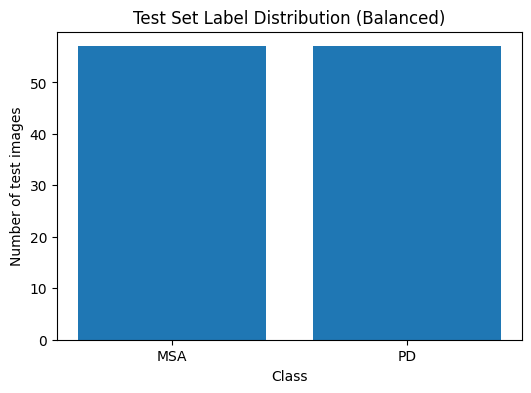


Test set counts and percentages:
MSA: 57 images (50.0% of test set)
PD: 57 images (50.0% of test set)


In [10]:
# --- Your Split Logic for 50/50 distribution in test set ---
print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

119 training images
21 test images
<class 'numpy.ndarray'>


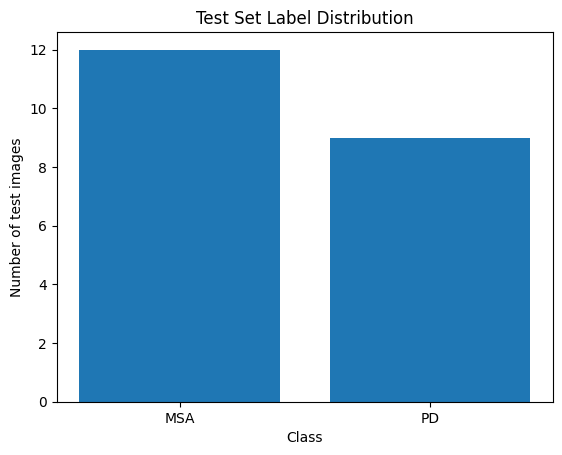

Label 0 (MSA): 12 images
Label 1 (PD): 9 images
Label 0 (MSA) is: 0.5714285714285714
Label 1 (PD) is: 0.42857142857142855


In [11]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= 0.15,
    stratify=labels,
    random_state=42,
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
# print("train images paths:", train_images_paths)
# print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
# print(test_images_paths)
print(type(train_images_paths))

unique_labels, counts = np.unique(test_true_labels_np, return_counts=True)


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [12]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id)

display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

,image_path,label,patient_id
0,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
1,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4092
2,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
3,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_4...,0,4121
4,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...,0,5358
...,...,...,...
135,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_74...,1,7461
136,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_75...,1,7544
137,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7677
138,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7688


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6491' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663' '6690'
 '6696' '6749' '6773' '6791' '7105' '7120' '7132' '7144' '7155' '7179'
 '7185' '7191' '7222' '7229' '7239' '7284' '7293' '7343' '7461' '7544'
 '7579' '7677' '7688' '7710']
Number of unique patients: 74
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
69,7544,1
70,7579,0
71,7677,1
72,7688,1


## TRAINING

In [ ]:
from re import I
from torch.utils.data import DataLoader
from torch.optim import AdamW
# Import PyTorch schedulers
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
import torchvision

# Lightly imports (make sure these are installed and correct)
from lightly.data import LightlyDataset
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
# Assuming BarlowTwinsProjectionHead and BarlowTwinsLoss are defined correctly elsewhere
# from your_module import BarlowTwinsProjectionHead, BarlowTwinsLoss

LEARNING_RATE = 3e-4 # Initial learning rate (peak after warmup)
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 250     # Or your desired number
WARMUP_EPOCHS = 10   # Number of epochs for linear warmup
BATCH_SIZE = 8      # Increase if GPU memory allows (e.g., 64, 128, 256)
NUM_WORKERS = 4
GRADIENT_CLIP_VAL = 1.0 # Max norm for gradient clipping
INPUT_DIR = ssl_images_folder_path
BARLOW_PROJECT_DIM = 2048 # Or your desired projection dim


# --- Helper function for linear warmup lambda ---
def linear_warmup_decay(warmup_steps):
    """ Linear warmup for warmup_steps steps. """
    def fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0 # Constant multiplier after warmup
    return fn

########################################################
# 2) Barlow Twins LightningModule
########################################################
class BarlowTwins(pl.LightningModule):
    def __init__(self, learning_rate, warmup_epochs, max_epochs):
        """
        ResNet18 backbone -> 512-d features
        Projection head -> (512 -> proj_dim -> proj_dim)
        BarlowTwinsLoss for self-supervised training
        """
        super().__init__()
        # Save hyperparameters like learning_rate, warmup_epochs, max_epochs
        # These are needed for scheduler setup in configure_optimizers
        self.save_hyperparameters()

        # Create ResNet18, initialized with ImageNet weights
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        resnet_output_dim = 512

        # Barlow Twins head
        self.projection_head = BarlowTwinsProjectionHead(
            resnet_output_dim,
            BARLOW_PROJECT_DIM,
            BARLOW_PROJECT_DIM
        )
        self.criterion = BarlowTwinsLoss()

        # Store steps_per_epoch, calculated in setup
        self.steps_per_epoch = 0

    # --- REVISED setup method ---
    def setup(self, stage=None):
        """Calculate steps_per_epoch after dataloader is available."""
        if stage == 'fit' or stage is None:
            # Check if trainer and dataloaders are available
            if not self.trainer or not self.trainer.train_dataloader:
                print("Warning: Trainer or train_dataloader not available in setup.")
                return

            try:
                # Get the length of the dataloader
                self.steps_per_epoch = len(self.trainer.train_dataloader)
                print(f"Calculated steps per epoch in setup: {self.steps_per_epoch}")

            except TypeError:
                # Handle cases where dataloader has no __len__ (e.g., IterableDataset)
                # Estimate based on limit_train_batches if set
                if self.trainer.limit_train_batches:
                     if isinstance(self.trainer.limit_train_batches, int):
                         self.steps_per_epoch = self.trainer.limit_train_batches
                     elif isinstance(self.trainer.limit_train_batches, float):
                          # Estimate requires dataset size, difficult to get reliably here
                          self.steps_per_epoch = 500 # Fallback guess
                          print(f"Warning: Cannot determine length from dataloader and limit_train_batches is a float.")
                          print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     else:
                          self.steps_per_epoch = 500 # Fallback guess
                          print(f"Warning: Unknown type for limit_train_batches.")
                          print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     print(f"Using limit_train_batches to set steps_per_epoch: {self.steps_per_epoch}")
                else:
                     # If no length and no limit, estimation is hard. Use a default with warning.
                     self.steps_per_epoch = 500 # Fallback guess
                     print(f"Warning: Could not determine dataloader length (possibly IterableDataset without length).")
                     print(f"Using fallback estimate for steps_per_epoch: {self.steps_per_epoch}")
                     print(f"For accurate scheduler behaviour, ensure train dataloader has __len__ or set trainer's limit_train_batches.")

            if self.steps_per_epoch == 0:
                 raise ValueError("Could not determine steps_per_epoch for LR scheduler. Aborting.")

    def forward(self, x):
        """ Forward pass for one augmented view x. """
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_idx):
        """ Barlow Twins requires two augmented views (x0, x1). """
        # Adapt based on actual batch structure from LightlyDataset
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
             (x0, x1), _, _ = batch # common case: (views), labels, fnames
        elif isinstance(batch, (list, tuple)) and len(batch) == 2 and isinstance(batch[0], (list, tuple)):
             (x0, x1), _ = batch # case: (views), labels
        elif isinstance(batch, (list, tuple)) and len(batch) == 1 and isinstance(batch[0], (list, tuple)):
             (x0, x1) = batch[0] # case: (views)
        else:
            # Attempt to handle dictionary batches if applicable
            try:
                 views = batch[0] # Assuming views are the first element if it's not a standard lightly format
                 if isinstance(views, (list, tuple)) and len(views) == 2:
                      x0, x1 = views
                 else:
                      raise TypeError("Could not extract two views from batch[0]")
            except (IndexError, KeyError, TypeError) as e:
                 raise ValueError(f"Unexpected batch format in training_step. Type: {type(batch)}, Content sample: {str(batch)[:100]}, Error: {e}")


        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)

        # Log loss and learning rate
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        optimizers = self.optimizers()
        # If multiple optimizers, take the first one
        optimizer = optimizers[0] if isinstance(optimizers, list) else optimizers
        lr = optimizer.param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        """ Use AdamW and a SequentialLR scheduler (Warmup + Cosine Decay). """
        optimizer = AdamW(self.parameters(),
                          lr=self.hparams.learning_rate,
                          weight_decay=WEIGHT_DECAY)

        # Ensure setup has run and calculated steps_per_epoch
        if self.steps_per_epoch == 0:
             # If setup didn't run or failed (e.g. Trainer(fast_dev_run=True))
             # Use a reasonable fallback, but warn the user.
             self.steps_per_epoch = 500
             print(f"Warning: steps_per_epoch was 0 in configure_optimizers. Using fallback: {self.steps_per_epoch}. "
                   "This might happen with fast_dev_run or if setup failed.")


        warmup_epochs = getattr(self, "warmup_epochs", getattr(self.hparams, "warmup_epochs", WARMUP_EPOCHS))
        max_epochs = getattr(self, "max_epochs", getattr(self.hparams, "max_epochs", MAX_EPOCHS))

        warmup_steps = self.steps_per_epoch * warmup_epochs
        # Adjust total_steps calculation based on max_epochs potentially changing
        if self.trainer and hasattr(self.trainer, "max_epochs") and self.trainer.max_epochs is not None:
            max_epochs = self.trainer.max_epochs
        total_steps = self.steps_per_epoch * max_epochs
        decay_steps = total_steps - warmup_steps

        # Ensure decay_steps is not negative if warmup_epochs >= max_epochs
        decay_steps = max(1, decay_steps)

        print(f"Optimizer: AdamW, Initial LR: {self.hparams.learning_rate}")
        print(f"Scheduler: SequentialLR(Warmup + CosineAnnealingLR)")
        print(f"  Total estimated steps: {total_steps}")
        print(f"  Warmup steps: {warmup_steps}")
        print(f"  Cosine decay steps: {decay_steps}")


        scheduler_warmup = LambdaLR(
            optimizer,
            lr_lambda=linear_warmup_decay(warmup_steps)
        )
        scheduler_cosine = CosineAnnealingLR(
            optimizer,
            T_max=decay_steps,
            eta_min=1e-7 # Slightly higher minimum LR
        )
        lr_scheduler = SequentialLR(
            optimizer,
            schedulers=[scheduler_warmup, scheduler_cosine],
            milestones=[warmup_steps]
        )

        scheduler_config = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler_config]

########################################################
# 3) Main Function to Run Training (Using PyTorch Schedulers)
########################################################
class BarlowTwinsProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim, bias=False),
        )
    def forward(self, x):
        return self.layers(x)

class BarlowTwinsLoss(nn.Module):
     def __init__(self, lambda_param=5e-3):
         super().__init__()
         self.lambda_param = lambda_param
     def forward(self, z_a: torch.Tensor, z_b: torch.Tensor) -> torch.Tensor:
         z_a_norm = (z_a - z_a.mean(0)) / (z_a.std(0) + 1e-6) # Add epsilon for stability
         z_b_norm = (z_b - z_b.mean(0)) / (z_b.std(0) + 1e-6) # Add epsilon for stability
         N = z_a.size(0)
         D = z_a.size(1)
         c = torch.mm(z_a_norm.T, z_b_norm) / N
         c_diff = (c - torch.eye(D, device=c.device)).pow(2)
         c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
         loss = c_diff.sum()
         return loss

# 1) Define Transforms
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=256, gaussian_blur=0.1),
    view_2_transform=BYOLView2Transform(input_size=256, gaussian_blur=0.1),
)

# Use torchvision.transforms.Compose, not monai.transforms.Compose
from torchvision.transforms import Compose
transform = Compose([transform])

# Convert ndarray to list for LightlyDataset compatibility
images_paths_list = ssl_images_paths_np.tolist()
# 2) Create Dataset
dataset = LightlyDataset(
    input_dir=INPUT_DIR,
    transform=transform,
    )
    # Optionally, you can pass labels if needed for debugging or logging

print(f"Dataset size: {len(dataset)}")

# 3) Create DataLoader
# Consider using pin_memory=True if using GPU and not seeing slowdowns
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    # pin_memory=True # Optional
)

# 4) Create the Barlow Twins model instance
model = BarlowTwins(learning_rate=LEARNING_RATE,
                    warmup_epochs=WARMUP_EPOCHS,
                    max_epochs=MAX_EPOCHS)

# 5) Setup Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar

lr_monitor = LearningRateMonitor(logging_interval='step')
progress_bar = TQDMProgressBar(refresh_rate=20)

# 6) Train with PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    callbacks=[lr_monitor, progress_bar],
    # logger= # Add logger if desired
    # log_every_n_steps=50
)

print("Starting Barlow Twins pre-training (using PyTorch LR schedulers)...")
# The trainer automatically calls model.setup('fit') before starting training
trainer.fit(model=model, train_dataloaders=dataloader)
print("Pre-training finished.")

# 7) After training, save ONLY the backbone
save_dir = "."
os.makedirs(save_dir, exist_ok=True)
backbone_save_path = os.path.join(save_dir, "barlow_backbone_stable_pytorch_sched.pth")

torch.save(model.backbone.state_dict(), backbone_save_path)
print(f"Stable Barlow Twins pretraining completed. Saved backbone to '{backbone_save_path}'.")

In [ ]:
# %%bash
# # Launch the training job in the background and return immediately
# nohup python -u barlow_tw_training.py > train.log 2>&1 &
# echo "Training started in background (PID=$!)  –  logs ➜ train.log"

In [ ]:
# %%bash
# head -n 50 train.log

In [ ]:
# %%bash
# list any train.py process that is still running
# pgrep -af "python .*barlow_tw_training.py" || echo "No train.py process found"

In [ ]:
# # lightning VERSION NOT WORKING --> IT CREATES EXPLODING GRADIENTS
# import pytorch_lightning as pl
# import torchvision
# from torch import nn
# from torch.utils.data import DataLoader

# # Lightly imports
# from lightly.data import LightlyDataset
# from lightly.loss import BarlowTwinsLoss
# from lightly.models.modules import BarlowTwinsProjectionHead
# from lightly.transforms.byol_transform import (
#     BYOLTransform, BYOLView1Transform, BYOLView2Transform
# )
# ########################################################
# # 1) Custom Callback to Print Epoch Loss
# ########################################################
# class PrintEpochLossCallback(pl.Callback): #inherits from pl.Callback
#     """
#     Prints the 'train_loss' metric (averaged over the epoch)
#     after each epoch ends, on a new console line.
#     """
#     def on_train_epoch_end(self, trainer, pl_module):
#         epoch_loss = trainer.callback_metrics.get("train_loss")
#         current_epoch = trainer.current_epoch
#         if epoch_loss is not None:
#             print(f"[Epoch {current_epoch}] => train_loss: {epoch_loss:.4f}")
#         else:
#             print(f"[Epoch {current_epoch}] => train_loss not found!")


# ########################################################
# # 2) Barlow Twins LightningModule
# ########################################################
# class BarlowTwins(pl.LightningModule):
#     def __init__(self):
#         """
#         ResNet18 backbone -> 512-d features
#         Projection head -> (512 -> 2048 -> 2048)
#         BarlowTwinsLoss for self-supervised training
#         """
#         super().__init__()
#         # Create ResNet18, remove the final FC layer
#         resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #TODO start using imagenet weights
#         # bnuild the backbone by removing the final FC layer from the resnet
#         self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)

#         # Barlow Twins head: 512 -> 2048 -> 2048
#         self.projection_head = BarlowTwinsProjectionHead(
#             512,  # input dimension from resnet18
#             2048,  # hidden dim
#             2048   # output dim
#         )
#         self.criterion = BarlowTwinsLoss()

#     def forward(self, x):
#         """
#         Forward pass for one augmented view x.
#         Returns the projected embedding (z).
#         """
#         # backbone output shape: (B,512,1,1)
#         x = self.backbone(x).flatten(start_dim=1)  # shape: (B,512)
#         z = self.projection_head(x)               # shape: (B,2048)
#         return z

#     def training_step(self, batch, batch_idx):
#         """
#         Barlow Twins requires two augmented views (x0, x1) of the same image.
#         We'll produce embeddings for each and compute the correlation loss.
#         """
#         (x0, x1) = batch[0]  # BYOLTransform returns a tuple: (x_query, x_key)
#         z0 = self.forward(x0)
#         z1 = self.forward(x1)

#         loss = self.criterion(z0, z1)

#         # Log the epoch-level average of 'train_loss'
#         self.log("train_loss", loss, on_step=False, on_epoch=True)
#         return loss

#     def configure_optimizers(self):
#         """
#         Simple SGD. Adjust the learning rate for your data scale.
#         """
#         optimizer = torch.optim.SGD(self.parameters(), lr=0.06, momentum=0.9, weight_decay=1e-4)
#         return optimizer


# ########################################################
# # 3) Main Function to Run Training
# ########################################################
# # 1) Create the Barlow Twins model
# model = BarlowTwins()
# encoder_type = "barlow_twins"  # or "moco" if using MoCo
# # 2) Define your transforms
# #    We'll use the BYOL transforms with 256×256 crops. 
# #    You can tune gaussian_blur, color jitter, etc.
# transform = BYOLTransform(
#     view_1_transform=BYOLView1Transform(input_size=256, gaussian_blur=0.1),
#     view_2_transform=BYOLView2Transform(input_size=256, gaussian_blur=0.1),
# )

# # 3) Create a dataset from your folder of unlabeled images
# #    e.g., "path/to/unlabeled" must contain .png, .jpg, etc.
# dataset = LightlyDataset(
#     input_dir=ssl_images_folder_path,
#     transform=transform
# )

# # 4) Create a DataLoader
# #    Adjust batch_size to fit your GPU memory. 
# #    If your dataset is very small, you can do batch_size=8 or 16.
# dataloader = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     drop_last=True,  # ensures pairs are well-defined
#     num_workers=4,
# )

# # 5) Train with PyTorch Lightning
# #    We disable the standard progress bar and print each epoch's loss ourselves.
# trainer = pl.Trainer(
#     max_epochs=250,
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     devices=1,
#     enable_progress_bar=False,
#     callbacks=[PrintEpochLossCallback()],
# )
# trainer.fit(model=model, train_dataloaders=dataloader)

# # 6) After training, you can save the ONLY the backbone
# torch.save(model.backbone.state_dict(),"barlow_backbone.pth")
# print("Barlow Twins pretraining completed. Saved backbone to 'barlow_backbone.pth'.")
# # Load the saved model
# resnet = torchvision.models.resnet18(weights=None)
#         # bnuild the backbone by removing the final FC layer from the resnet
# backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)
# backbone.load_state_dict(torch.load("barlow_backbone.pth"))

# print("Checking pre-trained backbone weights...")
# try:
#     # Recreate the backbone structure
#     resnet = torchvision.models.resnet18(weights=None)
#     backbone = nn.Sequential(*list(resnet.children())[:-1])
#     state_dict = torch.load("barlow_backbone.pth", map_location=torch.device('cpu')) # Load to CPU
#     backbone.load_state_dict(state_dict)

#     found_nan_inf = False
#     for name, param in backbone.named_parameters():
#         if torch.isnan(param).any() or torch.isinf(param).any():
#             print(f"!!! NaN or Inf found in backbone parameter: {name} !!!")
#             found_nan_inf = True

#     if not found_nan_inf:
#         print("Pre-trained backbone weights seem OK (no NaNs/Infs numerically).")
#         # If weights are OK, check their magnitude
#         max_abs_weight = 0.0
#         for name, param in backbone.named_parameters():
#              max_abs_weight = max(max_abs_weight, param.abs().max().item())
#         print(f"Maximum absolute weight value in backbone: {max_abs_weight}") # If this is huge (e.g., >1000), it indicates instability.

#     else:
#         print("!!! PROBLEM: Pre-trained backbone contains NaN/Inf weights! File is corrupt. !!!")
# except Exception as e:
#     print(f"Error loading or checking backbone weights: {e}")           
# # print("Barlow Twins pretraining completed. Saved backbone to 'barlow_backbone.pth'.")

In [ ]:
# import torchvision, copy, torch.nn as nn

# barlow_backbone = nn.Sequential(*list(torchvision.models.resnet18(weights=None).children())[:-1])
# _ = barlow_backbone.load_state_dict(torch.load("barlow_backbone.pth"))
# barlow_backbone.eval()          # good practice; will be copied later


# resnet = torchvision.models.resnet18(weights=None)
#         # bnuild the backbone by removing the final FC layer from the resnet
# backbone = nn.Sequential(*list(resnet.children())[:-1])  # shape (B,512,1,1)
# backbone.load_state_dict(torch.load("barlow_backbone.pth"))

<All keys matched successfully>

## loading pre-trained encoder


In [17]:
STABLE_BACKBONE_PATH = backbone_save_path
FEATURE_DIM = 512 # Output dimension of ResNet-18 backbone

# 1. Create the backbone architecture instance
#   Initialize with weights=None because we are loading our specific pre-trained weights.
print("1. Creating ResNet-18 backbone architecture (weights=None)...")
base_resnet = torchvision.models.resnet18(weights=None)
# The architecture saved was the ResNet excluding the final fully connected layer
pretrained_backbone = nn.Sequential(*list(base_resnet.children())[:-1])
print("   Architecture created.")

# 2. Load the saved state dictionary
print(f"\n2. Loading state dictionary from: {STABLE_BACKBONE_PATH}")
try:
    # Load to CPU first for flexibility, we'll move it to the correct device later
    state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=torch.device('cpu'))
    print("   State dictionary loaded from file.")
    # 3. Load the state_dict into the architecture instance
    print("\n3. Loading state dictionary into the backbone model instance...")
    pretrained_backbone.load_state_dict(state_dict)
    print("   Successfully loaded pre-trained weights into the backbone.")

except FileNotFoundError:
    print(f"   ERROR: Weight file not found at '{STABLE_BACKBONE_PATH}'.")
    print("   Please ensure the file exists and the path is correct.")
    # Handle the error appropriately - maybe exit or raise
    exit()

torch.manual_seed(42)  # For reproducibility
randomly_initialized_backbone = torchvision.models.resnet18(weights=None)
randomly_initialized_backbone = nn.Sequential(*list(randomly_initialized_backbone.children())[:-1])

1. Creating ResNet-18 backbone architecture (weights=None)...
   Architecture created.

2. Loading state dictionary from: ./barlow_backbone_stable_pytorch_sched.pth
   State dictionary loaded from file.

3. Loading state dictionary into the backbone model instance...
   Successfully loaded pre-trained weights into the backbone.


In [18]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [19]:
print(class_names)

['MSA', 'PD']


In [ ]:
from utils.data_visualization_functions import generate_cv_results_figure
from utils.train_functions import train_epoch, undersample_majority, val_epoch, train_epoch_mixUp, oversample_minority
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from utils.train_functions import SSLClassifierModule, BaseSSLClassifier

import torchvision, copy, torch.nn as nn


# barlow_encoder.eval()         

feature_dim = 512                             # ResNet-18 → 512

#########################################
import copy
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER = True  
bool_list = [True, False] 
for FREEZE_ENCODER in bool_list:
    for encoder in [pretrained_backbone, randomly_initialized_backbone]:
        if encoder == pretrained_backbone:
            encoder_type = "barlow"
        else:
            encoder_type = "random"
        
        def model_factory(lr: float)-> torch.nn.Module:
            """
            Model‐factory that instantiates a fresh SSLClassifierModule
            with the given learning rate.
            """
            fresh_encoder = copy.deepcopy(encoder)  # Create a fresh copy of the encoder
            return SSLClassifierModule(
                encoder=fresh_encoder,     # capture this from your outer scope
                num_classes=2,
                freeze_encoder=FREEZE_ENCODER,
                lr=lr,
                backbone_output_dim=feature_dim,
                # input_shape=(1,3,256,256),  # Adjust as needed (B, C, H, W)
            )
            

        from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
        # cfg.set_freezed_layer_index(None)
        experiment = NestedCVStratifiedByPatient(
            df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
            pretrained_weights = None,
            class_names = class_names, model_factory=model_factory, num_folds=6
        )
        # cfg.set_freezed_layer_index(None)
        # hold_out_cv = True
        using_cosine_scheduler = False

        per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


        from utils.mlflow_functions import log_SSL_run_to_mlflow
        def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
            """
            Get the index of the best fold based on a specified metric.

            Args:
                outer_fold_test_results (list of dict): List containing test results for 
                    each outer fold. Each element should be a dictionary with metrics 
                    as keys.
                metric (str): The metric name to use for selecting the best fold. 
                    Default is "test_balanced_acc".

            Returns:
                int: The index of the fold with the highest value for the specified metric.

            Example:
                best_idx = get_best_fold_idx(results, metric="test_f1")
            """

            print(outer_fold_test_results)
            best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
            # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
            best_fold_result = outer_fold_test_results[best_fold_idx]
            print(f"Best {metric} Fold Result: {best_fold_result}")
            fold_idx = best_fold_result["fold"]
            return fold_idx

        #loading the best model for the metric selected, it's then used for computing gradcams during logging
        best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
        model_instance_for_logging, _ = experiment._get_model_and_device()
        model_instance_for_logging.eval()
        try:
            model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
        except FileNotFoundError:
            raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
        except Exception as e:
            raise Exception(f"Error loading model weights: {str(e)}")

        # Now, call the logging function:
        train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
        # Now, call the logging function:
        # or "moco" if using MoCo
        log_SSL_run_to_mlflow(
            environmentFlags=environment_flags,
            cfg=cfg,
            model=model_factory(0.001),  # Pass a dummy model to log the run
            class_names=class_names,
            fold_results=outer_fold_test_results,
            per_fold_metrics=per_fold_training_metrics,
            hold_out_cv=True,
            test_transforms=val_transforms,
            all_images_paths_np=images_paths_np,
            all_labels_np=labels_np,
            test_images_paths_np=test_images_paths_np,
            test_true_labels_np=test_true_labels_np,
            yaml_path=yaml_path,
            color_transforms=False,
            model_library="torchvision",
            encoder_type= "barlow",
            pretrained_backbone_path = STABLE_BACKBONE_PATH,
            train_transforms=train_transforms,
            # val_transforms=val_transforms,
            freeze_encoder=FREEZE_ENCODER,
            ssl=True,
        )